In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #设置显示中文后,负号显示受影响,显示负号  
df = pd.read_csv(r"D:\DA\3.mysql\KDD99用户画像\creditcard.csv")
df.head()

,card_id,disp_id,issued,type,sex,age,last_days,balance,trans_count,trans_in_amount,trans_out_amount,out_ratio,out_in_ratio
0,1,9,1998-10-16,金卡,男,63.0438,1,71006,34,149157,157730,2.093368,1.057476
1,2,19,1998-03-13,普通卡,男,55.2438,3,48396,31,96980,96664,2.438307,0.996742
2,3,41,1995-09-03,金卡,男,27.0356,3,57962,31,154945,150442,2.406230,0.970938
3,4,42,1998-11-26,普通卡,男,63.3205,6,42325,42,208318,208988,3.896354,1.003216
4,5,51,1995-04-24,青年卡,女,15.4027,10,66181,41,157070,163224,2.552960,1.039180


# 信用风险评估

## 1.高风险客户特征分析

In [36]:
df["high_risk"] = df["out_in_ratio"].apply(lambda x: 1 if x>=1.5 else 0)

In [37]:
high_risk = df[df["high_risk"] == 1]
low_risk = df[df["high_risk"] == 0]
print("="*60 + "\n高风险客户统计描述:\n" + "="*60)
print(high_risk[['sex','age', 'trans_count', 'balance', 'last_days']].describe(percentiles=[.25, .5, .75]))

print("\n" + "="*60 + "\n非高风险客户统计描述:\n" + "="*60)
print(low_risk[['sex','age', 'trans_count', 'balance', 'last_days']].describe(percentiles=[.25, .5, .75]))

高风险客户统计描述:
             age  trans_count       balance  last_days
count  19.000000    19.000000     19.000000  19.000000
mean   27.261584    19.736842  33638.315789  10.368421
std    10.218971    11.019387  13576.437178   7.266441
min    12.969900    11.000000  11367.000000   1.000000
25%    20.173950    12.000000  25145.500000   4.500000
50%    25.780800    13.000000  31123.000000   9.000000
75%    33.294550    27.000000  37694.000000  13.500000
max    55.013700    42.000000  62670.000000  27.000000

非高风险客户统计描述:
              age  trans_count        balance   last_days
count  873.000000   873.000000     873.000000  873.000000
mean    38.552524    38.465063   57144.302405    5.885452
std     14.575889     9.608458   20542.653544    4.547727
min     12.624700    10.000000    -969.000000    1.000000
25%     25.424700    32.000000   43186.000000    2.000000
50%     38.567100    38.000000   54489.000000    5.000000
75%     51.200000    44.000000   69441.000000    8.000000
max     80.852100

可以看到一共有19位高风险客户，其平均年龄为27岁，而非高风险客户的平均年龄为38岁。此外，高风险客户的最后交易日期距开卡日期的时间间隔显著更长，平均周期为10天，相比之下，非高风险客户的平均周期为5天。

In [38]:
df[df["high_risk"]==1].groupby("sex").size()

sex
女    11
男     8
dtype: int64

In [39]:
df[df["high_risk"]==0].groupby("sex").size()

sex
女    412
男    461
dtype: int64

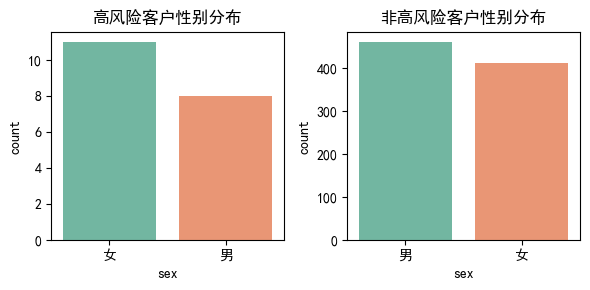

In [40]:
# 计算性别比例（假设sex为分类变量，如0/1或'M'/'F'）
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
sns.countplot(x='sex', data=high_risk,palette='Set2')
plt.title('高风险客户性别分布')

plt.subplot(1, 2, 2)
sns.countplot(x='sex', data=low_risk, palette='Set2')
plt.title('非高风险客户性别分布')
plt.tight_layout()
plt.show()

高风险客户中女性比例略高于男性，为11:8,非高风险客户中女性比例略低于男性，为412：461

## 2.风险成因挖掘

In [41]:
# 计算高风险和低风险组的出入账均值
high_risk_in_mean = df[df["high_risk"] == 1]["trans_in_amount"].mean()
low_risk_in_mean = df[df["high_risk"] == 0]["trans_in_amount"].mean()
high_risk_out_mean = df[df["high_risk"] == 1]["trans_out_amount"].mean()
low_risk_out_mean = df[df["high_risk"] == 0]["trans_out_amount"].mean()

# 创建DataFrame
risk_comparison = pd.DataFrame({
    "Metric": ["Mean In Amount", "Mean Out Amount"],
    "High Risk (1)": [high_risk_in_mean, high_risk_out_mean],
    "Low Risk (0)": [low_risk_in_mean, low_risk_out_mean]
})
# 计算高低风险组的差异比例
risk_comparison["Difference (High - Low)"] = risk_comparison["High Risk (1)"] - risk_comparison["Low Risk (0)"]
risk_comparison["Difference (%)"] = (risk_comparison["Difference (High - Low)"] / risk_comparison["Low Risk (0)"]) * 100
risk_comparison

,Metric,High Risk (1),Low Risk (0),Difference (High - Low),Difference (%)
0,Mean In Amount,16636.263158,174246.432990,-157610.169832,-90.452451
1,Mean Out Amount,40410.684211,169570.550974,-129159.866763,-76.168808


可见高风险人群的平均收入普遍较低，为非高风险人群的10%左右，支出为非高风险人群的25%左右，这种收支失衡导致其被标记为高风险客户，有可能存在因收入太低导致入不敷出或超前消费导致消费过度的情况。

In [42]:
# 计算关键统计量
stats_table = pd.DataFrame({
    "高风险客户": high_risk["last_days"].describe(),
    "非高风险客户": low_risk["last_days"].describe()
})
# 重命名行索引
stats_table.index = [
    "样本量", "平均值", "标准差", "最小值", 
    "25分位数", "中位数", "75分位数", "最大值"
]

print(stats_table)


           高风险客户      非高风险客户
样本量    19.000000  873.000000
平均值    10.368421    5.885452
标准差     7.266441    4.547727
最小值     1.000000    1.000000
25分位数   4.500000    2.000000
中位数     9.000000    5.000000
75分位数  13.500000    8.000000
最大值    27.000000   26.000000


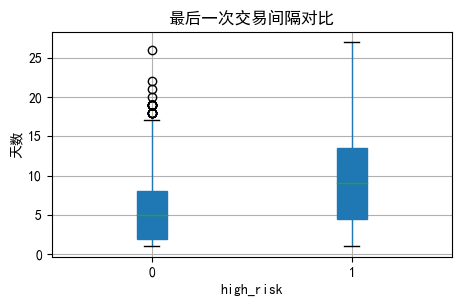

In [43]:
fig, ax = plt.subplots(figsize=(5, 3))  # 显式创建图形和坐标轴
df.boxplot(
    column="last_days",
    by="high_risk",
    patch_artist=True,
    labels=["非高风险客户", "高风险客户"],
    ax=ax  
)
plt.title("最后一次交易间隔对比")
plt.suptitle("")
plt.ylabel("天数")
plt.show()

高风险客户的 last_days较长表明他们近期没有新的交易记录，可能已因资金紧张停止使用账户，这类客户可能已无法维持正常收支，存在违约或坏账风险（如信用卡透支后无力偿还）。

# 客户画像与分群

In [44]:
conditions = [
    # 高价值客户：余额前40%、入账前40%、支出比例<0.9
    (df['balance'] >= df['balance'].quantile(0.6)) & 
    (df['trans_in_amount'] >= df['trans_in_amount'].quantile(0.6)) &
    (df['out_in_ratio'] < 0.9),
    
    # 高风险客户：支出比例>1.2、余额后30%、交易频率≥中位数
    (df['out_in_ratio'] > 1.2) & 
    (df['balance'] <= df['balance'].quantile(0.3)) &
    (df['trans_count'] >= df['trans_count'].median()),
    
    # 潜在流失客户：15天无交易且低频
    (df['last_days'] > 15) & 
    (df['trans_count'] <= df['trans_count'].median()),
    
    # 保守型客户：交易次数后50%、余额≥中位数
    (df['trans_count'] <= df['trans_count'].quantile(0.5)) & 
    (df['balance'] >= df['balance'].median()),
    
    # 活跃消费型客户：交易次数前50%、支出比例0.3~1.8
    (df['trans_count'] >= df['trans_count'].quantile(0.5)) &
    (df['out_in_ratio'].between(0.3, 1.8))
]

labels = ['高价值客户', '高风险客户', '潜在流失客户', '保守型客户', '活跃消费型客户']
df['label'] = np.select(conditions, labels, default='Other')

# 检查分布
print(df['label'].value_counts())

活跃消费型客户    383
Other      213
保守型客户      184
高价值客户       60
潜在流失客户      36
高风险客户       16
Name: label, dtype: int64


Text(0.5, 0, '')

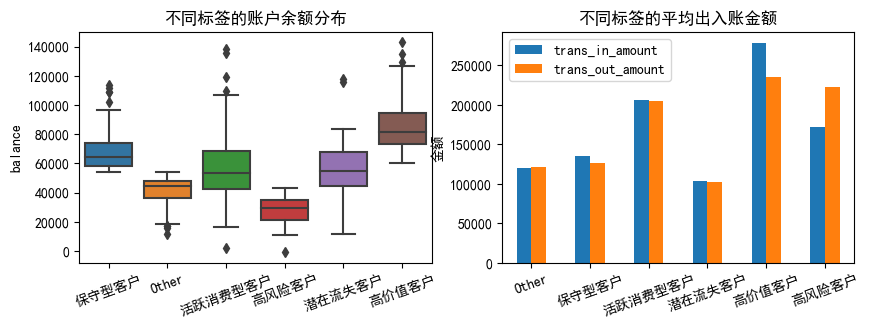

In [45]:
# 创建1行2列的图形布局
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# 第一个子图：箱线图
sns.boxplot(x='label', y='balance', data=df, ax=ax1)
ax1.set_title('不同标签的账户余额分布')
ax1.tick_params(axis='x', rotation=20)
ax1.set_xlabel('')  # 移除x轴标签

# 第二个子图：柱状图
df_grouped = df.groupby('label')[['trans_in_amount', 'trans_out_amount']].mean()
df_grouped.plot(kind='bar', ax=ax2)
ax2.set_title('不同标签的平均出入账金额')
ax2.set_ylabel('金额')
ax2.tick_params(axis='x', rotation=20)
ax2.set_xlabel('')  # 移除x轴标签

1.高价值客户账户余额高，资金流入多，消费或取现较少。推荐高收益理财产品、私人银行服务或大额存单；提供专属理财顾问，定制资产配置方案。

2.高风险客户（高出账比例、低余额、频繁交易）支出远高于收入（out_in_ratio > 1），余额低。可能存在套现、过度消费或财务压力。推荐分期还款或低利率贷款，避免逾期。 

3.潜在流失客户近期无交易或交易频率骤降，可能转向其他银行。召回激励：发放限时消费返现券或积分加倍奖励；客服电话回访，了解流失原因。

4.保守型客户（低交易频率、高余额）交易少，但账户余额高，可能是储蓄型用户。推荐定期存款、国债或低风险基金。提供“余额自动理财”功能，闲置资金自动转入货币基金。

5.活跃消费型客户（高频交易、出入账均衡）交易频繁，消费与收入均衡，可能是年轻白领或网购达人。推出“消费排行榜”或“好友拼单”功能，增强互动性；鼓励分享消费账单至社交媒体（如“年度消费报告”）。

# 消费行为分析

In [64]:
age_bins = [18, 25, 35, 45, 100]
age_labels = ['18-25', '26-35', '36-45', '46+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

age_stats = df.groupby(['age_group','sex']).agg({
    'trans_in_amount': ['mean', 'median'],
    'trans_out_amount': ['mean', 'median']
})

age_stats

trans_in_amount           trans_out_amount          
                         mean    median             mean    median
age_group sex                                                     
18-25     女     173075.025000  151240.0    174048.387500  150977.0
          男     151973.333333  136135.5    149699.214286  132078.0
26-35     女     187199.540230  144377.0    182998.137931  148496.0
          男     198041.623656  154129.0    197218.655914  150442.0
36-45     女     176910.337662  149475.0    170422.155844  144214.0
          男     187704.354430  153125.0    183135.721519  152952.0
46+       女     165164.666667  138219.0    156343.200000  132816.0
          男     166342.283422  142160.0    162200.828877  139770.0

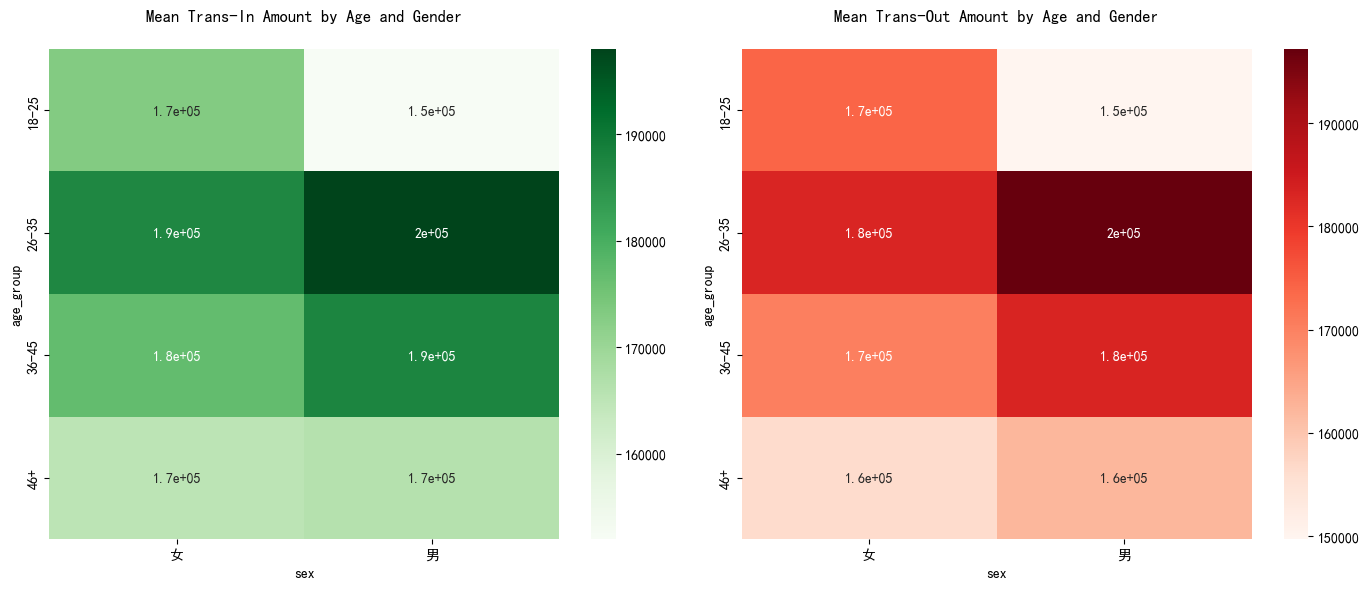

In [84]:
# 创建画布和子图（1行2列）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 第一个热力图：转入金额
pivot_in = df.pivot_table(index='age_group', columns='sex', values='trans_in_amount', aggfunc='mean')
sns.heatmap(pivot_in, annot=True, cmap='Greens', ax=ax1)
ax1.set_title('Mean Trans-In Amount by Age and Gender', pad=20)

# 第二个热力图：转出金额
pivot_out = df.pivot_table(index='age_group', columns='sex', values='trans_out_amount', aggfunc='mean')
sns.heatmap(pivot_out, annot=True, cmap='Reds', ax=ax2)
ax2.set_title('Mean Trans-Out Amount by Age and Gender', pad=20)

# 调整布局和显示
plt.tight_layout()
plt.show()

在26-45岁的人群中，男性的转入/转出金额均值和中位数均显著高于女性。18-25岁和46+岁年龄组的金额较低，可能与收入水平或消费需求下降有关。18-25岁女性的转入金额较高，可能与学生群体或家庭支持有关。26-35岁男性可能是高净值或高消费人群，值得重点关注。此外，无论是从性别维度还是年龄维度，均值都显著高于中位数，说明数据存在右偏分布（少数高额交易拉高了均值）。

